# Clustering and outlier detection for economic series

- KMeans, agglomerative, spectral clustering, nearest neighbors, PCA
- isolated forest, minimum covariance determinant, local outlier factor
- sklearn, FRED-MD

Terence Lim

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from copy import deepcopy
import os
import re
import time
from datetime import datetime
from finds.alfred import fred_md, Alfred
from finds.solve import lm, is_inlier
from settings import settings
imgdir = os.path.join(settings['images'], 'ts')

# Load and pre-process time series from FRED
alf = Alfred(api_key=settings['fred']['api_key'])
usrec = alf('USREC', freq='m')   # to indicate recession periods in the plots
usrec.index = pd.DatetimeIndex(usrec.index.astype(str), freq='infer')

g = usrec.astype(bool) | usrec.shift(-1, fill_value=0).astype(bool)
g = (g != g.shift(fill_value=0)).cumsum()[g].to_frame()
g = g.reset_index().groupby('USREC')['date'].agg(['first','last'])
vspans = [(v[0], v[1]) for k, v in g.iterrows()]

## Retrieve FRED-MD and apply transformations

In [2]:
# Retrieve FRED-MD series
mdf, mt = fred_md(202104)        # from vintage April 2020
beg = 19600301
end = 20201231 # 20191231

# Apply tcode transformations, DatetimeIndex, and sample beg:end
df = mdf
t = mt['transform']
transformed = []
for col in df.columns:
    transformed.append(alf.transform(df[col], tcode=t[col], freq='m'))
df = pd.concat(transformed, axis=1).iloc[2:]
data = df[(df.index >= beg) & (df.index <= end)].dropna(axis=1)
data.index = pd.DatetimeIndex(data.index.astype(str), freq='infer')
cols = list(data.columns)
data

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RETAIL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
1960-03-31,0.001910,0.000918,0.014072,-0.028021,-0.001102,-0.009017,-0.003429,-0.001146,0.001154,-0.019963,...,-0.004555,0.001786,-0.001025,-0.000020,0.030131,-0.004684,0.002087,0.003472,0.000951,0.003490
1960-04-30,0.003426,0.003621,0.015382,0.009836,0.025903,-0.007961,0.002287,0.001146,0.006880,-0.001189,...,0.004119,0.004439,0.001531,-0.008949,-0.068074,0.000000,-0.000701,0.008678,0.005452,0.024136
1960-05-31,0.002403,0.002448,-0.020417,-0.031588,-0.015047,-0.001143,0.005691,0.006866,0.005698,0.009454,...,-0.001298,-0.006723,0.000504,0.008949,0.041620,0.000000,0.000688,-0.004827,-0.002067,0.003798
1960-06-30,0.000789,-0.000249,-0.000219,0.008606,-0.001364,-0.012650,-0.011414,-0.011467,-0.006841,-0.010645,...,-0.002633,0.000222,-0.000768,-0.004474,-0.011429,0.000000,0.001027,0.005126,0.007420,-0.009981
1960-07-31,0.001832,0.001905,0.002028,-0.006865,-0.010099,-0.003479,-0.005760,-0.005783,-0.009197,-0.038793,...,0.002844,0.001828,0.000672,0.004454,0.007547,0.000000,0.001358,-0.010926,-0.003291,0.032176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,-0.030585,0.010232,0.009006,0.002694,0.008110,0.009570,0.013903,0.013584,0.009432,-0.008437,...,0.001544,-0.000919,0.000512,-0.002756,0.003408,-0.008366,-0.002452,-0.005675,-0.002656,-0.016155
2020-09-30,0.005424,0.009202,0.011195,0.006225,0.020001,-0.000833,-0.004155,-0.007736,-0.009875,-0.014429,...,-0.008339,-0.004848,0.001022,-0.001961,-0.013327,0.004790,0.006721,-0.001469,0.002209,-0.001298
2020-10-31,-0.007131,0.006579,0.002710,0.005327,0.000928,0.010576,0.011686,0.007771,0.004466,0.008636,...,-0.000601,0.001638,-0.002300,0.004309,0.020860,-0.006972,-0.002690,-0.008596,-0.005963,0.004761
2020-11-30,-0.012452,-0.007142,-0.006493,-0.001800,-0.013646,0.008970,0.005644,0.006273,0.003317,0.016860,...,-0.001356,0.002494,-0.001035,0.000766,-0.005511,0.005643,0.003513,0.005337,0.004147,0.005019


## Outlier Detection: single time series
- 10iq (interquartile range), or other multiple, around the median
- Tukey proposed 1.5iq, and 3iq for farout, beyond 1Q and 3Q values


In [4]:
outliers = DataFrame({method: (~is_inlier(data, method=method)).mean(axis=1)
                      for method in ['farout', 'iq10']}, index=data.index)

print("Months with most data points identified as time-series outliers")
for label in outliers.columns:
    print(outliers[[label]].sort_values(by=label, ascending=False)[:5].T) 
    print()

Months with most data points identified as time-series outliers
        2020-04-30  2020-05-31  2020-03-31  2020-06-30  2009-01-31
farout    0.446281    0.380165    0.371901    0.330579    0.247934

      2020-04-30  2020-06-30  2020-05-31  2020-03-31  1980-05-31
iq10     0.31405    0.090909    0.090909    0.041322    0.033058



## Outlier Detection -- multidimensional features

Isolation Forest
- Isolates observations by randomly selecting a feature and then
  randomly selecting a split value: normality is measured by the
  number of splittings required to isolate a sample -- single feature

Minimum Covariance Determinant (MCD)
- Assume that the regular data come from a known distribution, such as
  Gaussian, define outlying observations which stand far enough from
  the fit shape - global multidimensional

Local Outlier Factor (LOF) 
- Computes a score reflecting the local density deviation of a given
  data point with respect to its neighbors, as the measure of
  abnormality -- local multidimensional


In [5]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

def detects(label=None, frac=None):
    """list of outlier detection algorithms to select from"""
    algo = {'isoForest': IsolationForest(contamination=frac, random_state=42),
            'MCD': EllipticEnvelope(contamination=frac),
            'LOF': LocalOutlierFactor(n_neighbors=20, contamination=frac)}
    return list(algo.keys()) if label is None else algo[label]

## Run outlier detection algorithms

In [7]:
spans = dict()              
for label in detects():
    spans[label] = dict()
    tic = time.time()
    for frac in [0.005, 0.02]:  # specify contamination fractions
        y = detects(label, frac).fit_predict(data)
        spans[label][frac] = [(d - pd.DateOffset(months=1), d)
                              for d in data.index[y<0]]
    print(f"{label}: {time.time()-tic:.0f} secs elapsed")

isoForest: 1 secs elapsed
MCD: 27 secs elapsed
LOF: 0 secs elapsed


## Display outlier regions


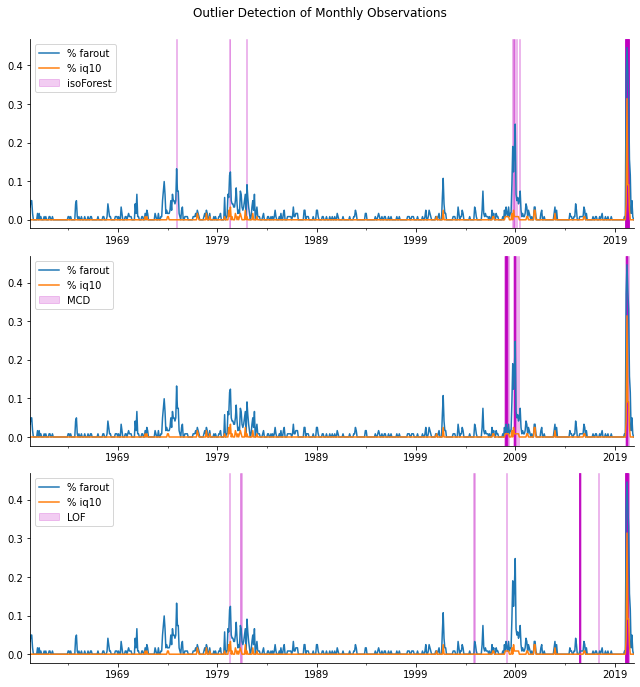

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1, num=1, clear=True, figsize=(9,10))
for (label, span), ax in zip(spans.items(), axes):
    outliers.plot(ax=ax)
    for i, frac in enumerate(sorted(span.keys(), reverse=True)):
        for a,b in span[frac]:
            ax.axvspan(a, b, alpha=0.2 + 0.6*i, color='m')
    ax.legend(['% ' + c for c in outliers.columns] + [label],
              loc='upper left')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"Outlier Detection of Monthly Observations")
plt.savefig(os.path.join(imgdir, 'anomaly.jpg'))
plt.show()

# Clustering economic series
- input y should have shape (n_samples=variables, n_features=monthly values)
- StandardScaler standardizes by column: but we want to normalize by variable
  hence first apply StandardScaler to (monthly values, variables), then tranpose

In [9]:
from sklearn.preprocessing import StandardScaler
y = StandardScaler().fit_transform(np.asarray(data)).T
within_rsq = dict()    # collect average within-cluster rsquareds
total_rsq = dict()     # collect total rsquareds
max_clusters = 8

# helpers to show explained variance
def cluster_rsq(y, centers, labels=None):
    """Calculate within-cluster average rsquared of y to its labelled center"""
    if labels is None:
        return np.mean(lm(y=y.T, x=centers.T).rsq)
    labels = labels.flatten()
    return np.sum([np.sum(lm(y=y.T[:, labels == p], x=centers.T[:,p]).rsq)
                   for p in np.unique(labels)]) / len(labels)


from sklearn.neighbors import NearestNeighbors
def print_nearest(centers, neighbors, labels, n_neighbors=3):
    """Display each center's labeled neighbors, and variance explained"""
    
    c = centers / centers.std(ddof=0, axis=1)[:, None]   # standardize centers
    l = labels.flatten()
    neigh = NearestNeighbors(n_neighbors, radius=None, algorithm='brute')
    for k in range(c.shape[0]):
        # find nearest labelled neighbors of center[k]
        sz = np.sum(l == k)
        r2 = cluster_rsq(neighbors[l==k], c[[k]])
        print(f"Cluster:{k:2d}  size:{sz}  R2:{r2:.3f}")
        if n_neighbors:
            neigh.fit(neighbors[l==k])
            dist, nearest = neigh.kneighbors(c[[k]], min(sz, n_neighbors),
                                             return_distance=True)
            for arg in nearest[0]:
                col = np.array(cols)[l==k][arg]
                print(f"{col:16s} {alf.header(col)}")
            print()
    print()


## KMeans clustering 
- default initialization is k-means++

In [10]:
from sklearn.cluster import KMeans

modelname = 'KMeans'
rsq, ttl = dict(), dict()
for n_clusters in range(2, max_clusters+1):
#    km = MiniBatchKMeans(n_clusters=n_clusters, batch_size=6, max_iter=100)
    km = KMeans(n_clusters=n_clusters, max_iter=100)    
    best = 0.0
    for trial in range(10):  # kmeans may get stuck in local optimums
        km.fit(y)
        r = cluster_rsq(y, km.cluster_centers_, km.labels_)
        if r > best:
            best = r
            kmeans = deepcopy(km)
            rsq[n_clusters] = best
            ttl[n_clusters] = lm(y=y.T, x=km.cluster_centers_.T).rsq.mean()
within_rsq[modelname] = rsq
total_rsq[modelname] = ttl

# show clusters
print(f"Model [{modelname}] Average Within-clusters Rsquare:",
      f"{cluster_rsq(y, kmeans.cluster_centers_, kmeans.labels_):.3f}")
print(f"Total Rsquare: {lm(y=y.T, x=kmeans.cluster_centers_.T).rsq.mean():.3f}")
print_nearest(kmeans.cluster_centers_, neighbors=y, labels=kmeans.labels_)

Model [KMeans] Average Within-clusters Rsquare: 0.460
Total Rsquare: 0.501
Cluster: 0  size:13  R2:0.631
CUSR0000SAC      Consumer Price Index for All Urban Consumers: Commodities in U.S. City Average
DNDGRG3M086SBEA  Personal consumption expenditures: Nondurable goods (chain-type price index)
CUSR0000SA0L2    Consumer Price Index for All Urban Consumers: All Items Less Shelter in U.S. City Average

Cluster: 1  size:21  R2:0.084
CONSPI           Nonrevolving consumer credit to Personal Income
AWHMAN           Average Weekly Hours of Production and Nonsupervisory Employees, Manufacturing
CES0600000007    Average Weekly Hours of Production and Nonsupervisory Employees, Goods-Producing

Cluster: 2  size:36  R2:0.549
IPMANSICS        Industrial Production: Manufacturing (SIC)
IPFPNSS          Industrial Production: Final Products and Nonindustrial Supplies
PAYEMS           All Employees, Total Nonfarm

Cluster: 3  size:10  R2:0.770
HOUST            New Privately-Owned Housing Units Started

# PCA components as cluster centers


In [11]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

modelname = 'PCA'
rsq, ttl = dict(), dict()
for n_clusters in range(2, max_clusters+1):
    pca = PCA(n_components=n_clusters).fit(y)
    
    ## assign label as nearest center
    centers = pca.components_ / pca.components_.std(ddof=0, axis=1)[:, None]
    neigh = NearestNeighbors(1, algorithm='brute', radius=None).fit(centers)
    dists, labels = neigh.kneighbors(y, return_distance=True)
    
    rsq[n_clusters] = cluster_rsq(y, centers, labels)
    ttl[n_clusters] = lm(y=y.T, x=centers.T).rsq.mean()
within_rsq[modelname] = rsq
total_rsq[modelname] = ttl

# show clusters
print(f"Model [{modelname}] Average Within-cluster Rsquare:",
      f"{cluster_rsq(y, centers, labels):.03f}")
print(f"Total Rsquare: {lm(y=y.T, x=centers.T).rsq.mean():.3f}")
print_nearest(centers, neighbors=y, labels=labels)


Model [PCA] Average Within-cluster Rsquare: 0.135
Total Rsquare: 0.530
Cluster: 0  size:12  R2:0.254
UNRATE           Unemployment Rate
ISRATIO          Total Business: Inventories to Sales Ratio
UEMPLT5          Number Unemployed for Less Than 5 Weeks

Cluster: 1  size:17  R2:0.188
HOUST            New Privately-Owned Housing Units Started: Total Units
HOUSTS           New Privately-Owned Housing Units Started: Total Units in the South Census Region
PERMIT           New Privately-Owned Housing Units Authorized in Permit-Issuing Places: Total Units

Cluster: 2  size:6  R2:0.388
AAAFFM           Moody's Seasoned Aaa Corporate Bond Minus Federal Funds Rate
T10YFFM          10-Year Treasury Constant Maturity Minus Federal Funds Rate
BAAFFM           Moody's Seasoned Baa Corporate Bond Minus Federal Funds Rate

Cluster: 3  size:18  R2:0.123
AAA              Moody's Seasoned Aaa Corporate Bond Yield
BAA              Moody's Seasoned Baa Corporate Bond Yield
GS5              5-Year Treasury 

# Spectral clustering

In [12]:
from sklearn.cluster import SpectralClustering

modelname = 'Spectral'
rsq, ttl = dict(), dict()
for n_clusters in range(2, max_clusters+1):
    spectral = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack',
                                  affinity="nearest_neighbors").fit(y)
    
    # assign centers as medians of each feature (monthly values)
    centers = np.hstack([StandardScaler()\
                         .fit_transform(np.median(y[spectral.labels_ == c],
                                                  axis=0).reshape(-1,1))
                         for c in range(max(spectral.labels_+1))]).T
    
    rsq[n_clusters] = cluster_rsq(y, centers, spectral.labels_)
    ttl[n_clusters] = lm(y=y.T, x=centers.T).rsq.mean()
within_rsq[modelname] = rsq
total_rsq[modelname] = ttl

# show clusters
print(f"Model [{modelname}] Average Within-cluster Rsquare:",
      f"{cluster_rsq(y, centers, spectral.labels_):.03f}")
print(f"Total Rsquare: {lm(y=y.T, x=centers.T).rsq.mean():.3f}")
print_nearest(centers, neighbors=y, labels=spectral.labels_)


Model [Spectral] Average Within-cluster Rsquare: 0.442
Total Rsquare: 0.491
Cluster: 0  size:19  R2:0.407
CUSR0000SAC      Consumer Price Index for All Urban Consumers: Commodities in U.S. City Average
CUSR0000SA0L2    Consumer Price Index for All Urban Consumers: All Items Less Shelter in U.S. City Average
DNDGRG3M086SBEA  Personal consumption expenditures: Nondurable goods (chain-type price index)

Cluster: 1  size:11  R2:0.505
GS1              1-Year Treasury Constant Maturity Rate
GS5              5-Year Treasury Constant Maturity Rate
TB6MS            6-Month Treasury Bill: Secondary Market Rate

Cluster: 2  size:11  R2:0.224
S&P 500          S&P's Common Stock Price Index: Composite
S&P: indust      S&P's Common Stock Price Index: Industrials
S&P PE ratio     S&P's Composite Common Stock: Price-Earnings Ratio

Cluster: 3  size:14  R2:0.266
UNRATE           Unemployment Rate
UEMPLT5          Number Unemployed for Less Than 5 Weeks
CLAIMS           Initial Claims

Cluster: 4  size:

# Ward Hierarchical Clustering

In [14]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
connectivity = kneighbors_graph(y, n_neighbors=len(y)//2, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)

from sklearn.cluster import SpectralClustering

modelname = 'Ward'
rsq, ttl = dict(), dict()
for n_clusters in range(2, max_clusters+1):
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                   connectivity=connectivity).fit(y)

    # assign centers as means of each feature (monthly values)
    centers = np.hstack([StandardScaler()\
                         .fit_transform(np.mean(y[ward.labels_ == c],
                                                axis=0).reshape(-1,1))
                     for c in range(max(ward.labels_+1))]).T

    rsq[n_clusters] = cluster_rsq(y, centers, ward.labels_)
    ttl[n_clusters] = lm(y=y.T, x=centers.T).rsq.mean()
within_rsq[modelname] = rsq
total_rsq[modelname] = ttl

# show clusters
print(f"Model [{modelname}] Average Within-cluster Rsquare:",
      f"{cluster_rsq(y, centers, ward.labels_):.03f}")
print(f"Total Rsquare: {lm(y=y.T, x=centers.T).rsq.mean():.3f}")
print_nearest(centers, neighbors=y, labels=ward.labels_)

Model [Ward] Average Within-cluster Rsquare: 0.453
Total Rsquare: 0.503
Cluster: 0  size:7  R2:0.376
S&P PE ratio     S&P's Composite Common Stock: Price-Earnings Ratio
UEMP15OV         Number Unemployed for 15 Weeks & Over
S&P: indust      S&P's Common Stock Price Index: Industrials

Cluster: 1  size:35  R2:0.554
IPMANSICS        Industrial Production: Manufacturing (SIC)
PAYEMS           All Employees, Total Nonfarm
USGOOD           All Employees, Goods-Producing

Cluster: 2  size:12  R2:0.673
CUSR0000SAC      Consumer Price Index for All Urban Consumers: Commodities in U.S. City Average
DNDGRG3M086SBEA  Personal consumption expenditures: Nondurable goods (chain-type price index)
CUSR0000SA0L2    Consumer Price Index for All Urban Consumers: All Items Less Shelter in U.S. City Average

Cluster: 3  size:34  R2:0.049
AMDMUO           Manufacturers' Unfilled Orders: Durable Goods
CES0600000008    Average Hourly Earnings of Production and Nonsupervisory Employees, Goods-Producing
CES0600

# AverageLinkage Hierarchical Clustering
- with cityblock distance

In [15]:
# with cityblock distance
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
connectivity = kneighbors_graph(y, n_neighbors=len(y)//2, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)

modelname = 'AvgLink'
rsq, ttl = dict(), dict()
for n_clusters in range(2, max_clusters+1):
    avglink = AgglomerativeClustering(linkage="average", affinity="cityblock",
                                      n_clusters=n_clusters,
                                      connectivity=connectivity).fit(y)

    # assign centers as means of each feature (monthly values)
    centers = np.hstack([StandardScaler()\
                         .fit_transform(np.mean(y[avglink.labels_ == c],
                                                axis=0).reshape(-1,1))
                     for c in range(max(avglink.labels_+1))]).T

    rsq[n_clusters] = cluster_rsq(y, centers, avglink.labels_)
    ttl[n_clusters] = lm(y=y.T, x=centers.T).rsq.mean()
within_rsq[modelname] = rsq
total_rsq[modelname] = ttl

# show clusters
print(f"Model [{modelname}] Average Within-cluster Rsquare:",
      f"{cluster_rsq(y, centers, avglink.labels_):.03f}")
print(f"Total Rsquare: {lm(y=y.T, x=centers.T).rsq.mean():.3f}")
print_nearest(centers, neighbors=y, labels=avglink.labels_)

Model [AvgLink] Average Within-cluster Rsquare: 0.292
Total Rsquare: 0.326
Cluster: 0  size:100  R2:0.193
IPMANSICS        Industrial Production: Manufacturing (SIC)
CUMFNS           Capacity Utilization: Manufacturing (SIC)
USGOOD           All Employees, Goods-Producing

Cluster: 1  size:3  R2:0.521
EXSZUS           Switzerland / U.S. Foreign Exchange Rate
EXJPUS           Japan / U.S. Foreign Exchange Rate
EXCAUS           Canada / U.S. Foreign Exchange Rate

Cluster: 2  size:2  R2:0.732
IPNCONGD         Industrial Production: Non-Durable Consumer Goods
IPB51222S        Industrial Production: Non-Durable Consumer Energy Products: Residential Utilities

Cluster: 3  size:10  R2:0.770
HOUST            New Privately-Owned Housing Units Started: Total Units
PERMIT           New Privately-Owned Housing Units Authorized in Permit-Issuing Places: Total Units
HOUSTW           New Privately-Owned Housing Units Started: Total Units in the West Census Region

Cluster: 4  size:2  R2:0.649
CUSR00

## Plot within-cluster and total variance explained
- PCA seeks to maximize total rsquare

- KMeans (with Euclidean distance) seeks to maximize within-cluster rsquare

- Average Linking method used Manhattan rather than Euclidean distances, hence 
  appears poorer through  "variance explained" (or Euclidean) metrics


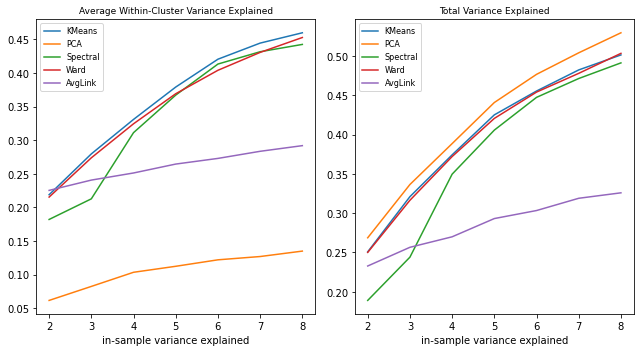

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,5), num=1, clear=True)
for v, title, ax in zip([DataFrame(within_rsq), DataFrame(total_rsq)],
                        ['Average Within-Cluster Variance Explained',
                         'Total Variance Explained'], axes.ravel()):
    v.plot(ax=ax, style='-', rot=0)
    ax.set_xlabel('number of clusters')
    ax.set_xlabel('in-sample variance explained')
    ax.set_title(title, {'fontsize':9})
    ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'clusters.jpg'))
plt.show()